# Train first Meta Model
- Train first Meta Model on X_train
- Train LogReg on RE of Meta Model

In [1]:
import arrow
import learn2learn as l2l
import numpy as np
import os
import pickle
import torch
from torch.nn import Module, Linear, Sequential, ReLU
from torch.nn.functional import mse_loss
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils.evalUtils import print_confusion_matrix

from sklearn.preprocessing import MinMaxScaler

In [2]:
%run -i ./scripts/setConfigs.py

Set configs..


## Prepare data

In [4]:
data_fn = os.path.join(data_path, 'simulation_data_y_2020_2021_reduced.h5')
df_data_train = pd.read_hdf(data_fn, key='df')
print('Shape of X_train data: {}'.format(df_data_train.shape))

Shape of X_train data: (105216, 17)


In [5]:
fake_labels = np.ones(len(df_data_train))

In [6]:
print('Scale data..')
scaler_train = MinMaxScaler((-1,1))
scaler_train = scaler_train.fit(df_data_train)
scaled_train = scaler_train.transform(df_data_train.to_numpy())

Scale data..


In [7]:
len(scaled_train)

105216

In [8]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train, fake_labels, train_size=0.8, random_state=42)

In [9]:
assert len(scaled_train) == len(X_test) + len(X_train)
assert len(scaled_train) == len(y_test) + len(y_train)

In [10]:
# build tensor from numpy
train_torch_tensor_X = torch.from_numpy(X_train).type(torch.FloatTensor)
train_torch_tensor_y = torch.from_numpy(y_train.reshape(len(y_train),1)).type(torch.FloatTensor)

test_torch_tensor_X = torch.from_numpy(X_test).type(torch.FloatTensor)
test_torch_tensor_y = torch.from_numpy(y_test.reshape(len(y_test),1)).type(torch.FloatTensor)

In [11]:
# build pytorch dataset from tensor
train_dataset = TensorDataset(train_torch_tensor_X, train_torch_tensor_y)
test_dataset = TensorDataset(test_torch_tensor_X, test_torch_tensor_y)

In [12]:
# create MetaDatasets from l2l
train_metadataset = l2l.data.MetaDataset(train_dataset)
test_metadataset = l2l.data.MetaDataset(test_dataset)

In [1]:
# build l2l MetaDataset and TaskDataset for sampling
train_tasks = l2l.data.TaskDataset(train_metadataset,
                                   task_transforms=[
                                        l2l.data.transforms.NWays(train_metadataset, n=1),
                                        l2l.data.transforms.KShots(train_metadataset, k=5),
                                        l2l.data.transforms.LoadData(train_metadataset)],
                                   num_tasks=128)

eval_tasks = l2l.data.TaskDataset(test_metadataset,
                                   task_transforms=[
                                        l2l.data.transforms.NWays(test_metadataset, n=1),
                                        l2l.data.transforms.KShots(test_metadataset, k=1),
                                        l2l.data.transforms.LoadData(test_metadataset),
                                   ],
                                   num_tasks=32)

NameError: name 'l2l' is not defined

## Load AE Model

In [14]:
%run -i ./scripts/ReadSimpleAE.py

++++++++++++++++++++++++++++++
Load untrained simple AE..
----------
Load model: /home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200302_firstAE_model.pt
----------
SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=17, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=8, bias=True)
    (3): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=17, bias=True)
    (3): Tanh()
  )
)
----------
Set model in train mode!
++++++++++++++++++++++++++++++


### Visualize Weight Initialization

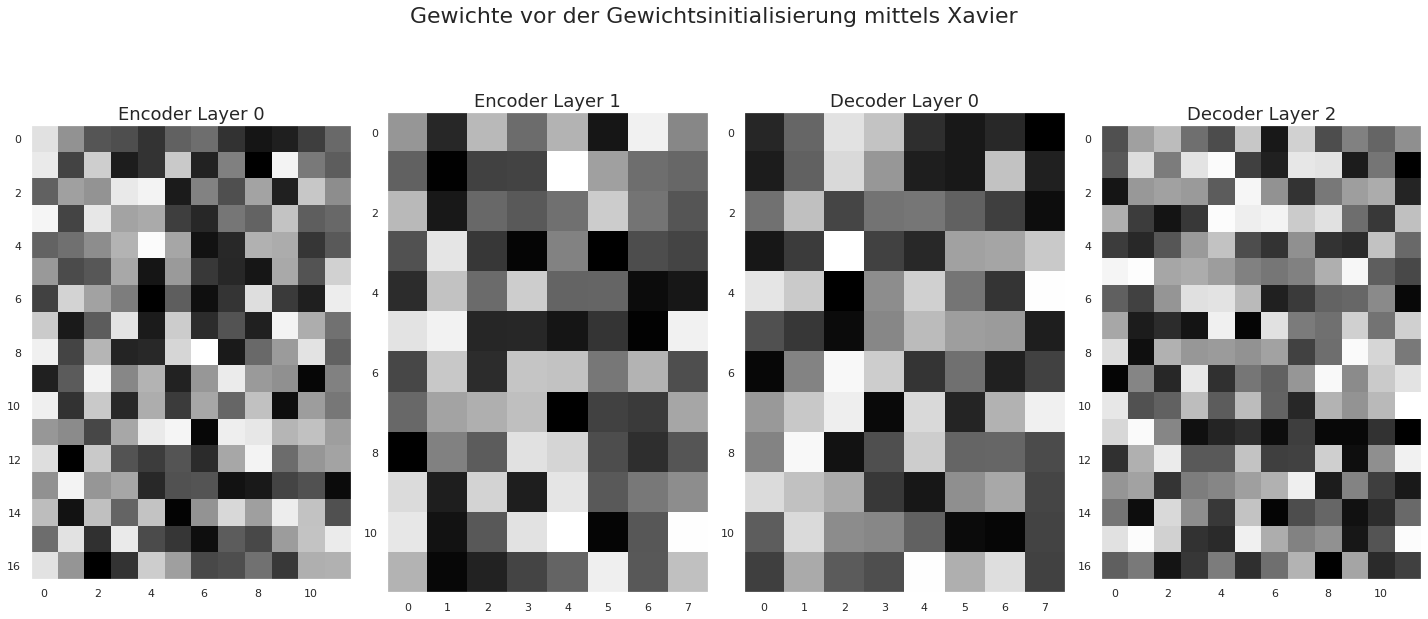

In [15]:
fig, ax = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(20, 10)

ax[0].imshow(model.encoder[0].weight.detach().numpy().T, cmap="gray")
ax[0].grid(False)
ax[0].set_title('Encoder Layer 0', fontsize=18)

ax[1].imshow(model.encoder[2].weight.detach().numpy().T, cmap="gray")
ax[1].grid(False)
ax[1].set_title('Encoder Layer 1', fontsize=18)

ax[2].imshow(model.decoder[0].weight.detach().numpy(), cmap="gray")
ax[2].grid(False)
ax[2].set_title('Decoder Layer 0', fontsize=18)

ax[3].imshow(model.decoder[2].weight.detach().numpy(), cmap="gray")
ax[3].grid(False)
ax[3].set_title('Decoder Layer 2', fontsize=18)
fig.suptitle('Gewichte vor der Gewichtsinitialisierung mittels Xavier', fontsize=22)
plt.tight_layout()

In [16]:
model = model.apply(SimpleAutoEncoder.weight_init)

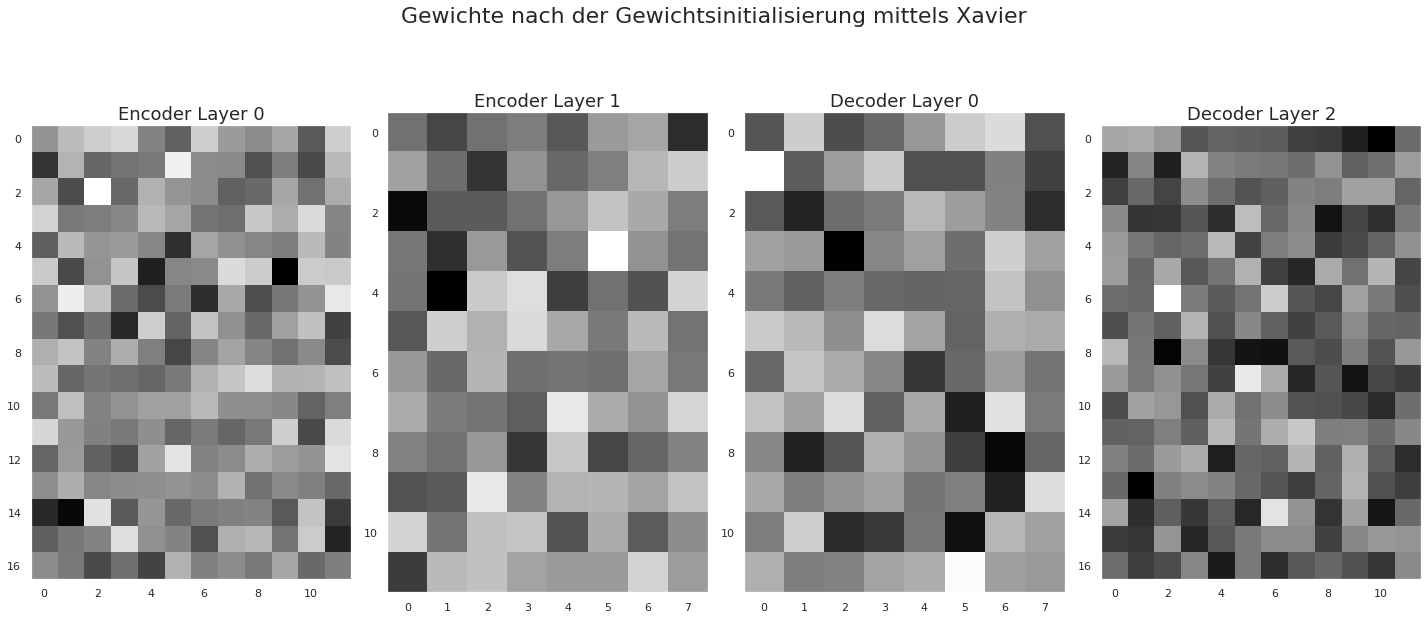

In [17]:
fig, ax = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(20, 10)

ax[0].imshow(model.encoder[0].weight.detach().numpy().T, cmap="gray")
ax[0].grid(False)
ax[0].set_title('Encoder Layer 0', fontsize=18)

ax[1].imshow(model.encoder[2].weight.detach().numpy().T, cmap="gray")
ax[1].grid(False)
ax[1].set_title('Encoder Layer 1', fontsize=18)

ax[2].imshow(model.decoder[0].weight.detach().numpy(), cmap="gray")
ax[2].grid(False)
ax[2].set_title('Decoder Layer 0', fontsize=18)

ax[3].imshow(model.decoder[2].weight.detach().numpy(), cmap="gray")
ax[3].grid(False)
ax[3].set_title('Decoder Layer 2', fontsize=18)
fig.suptitle('Gewichte nach der Gewichtsinitialisierung mittels Xavier', fontsize=22)
plt.tight_layout()

## Meta Learning

In [18]:
from MetaLearner.Learner import Learner

In [19]:
learner = Learner(model=model, train_task_dataset=train_tasks, eval_task_dataset=eval_tasks, num_iterations=400, optimizer='Adam')

In [20]:
learner.start_learning_phase()

Adaption Error: 0.011112, Validation Error: 0.001408: 100%|██████████| 400/400 [37:43<00:00,  5.66s/it]


In [21]:
adapt_loss = learner.adaption_loss
eval_loss = learner.evaluation_loss

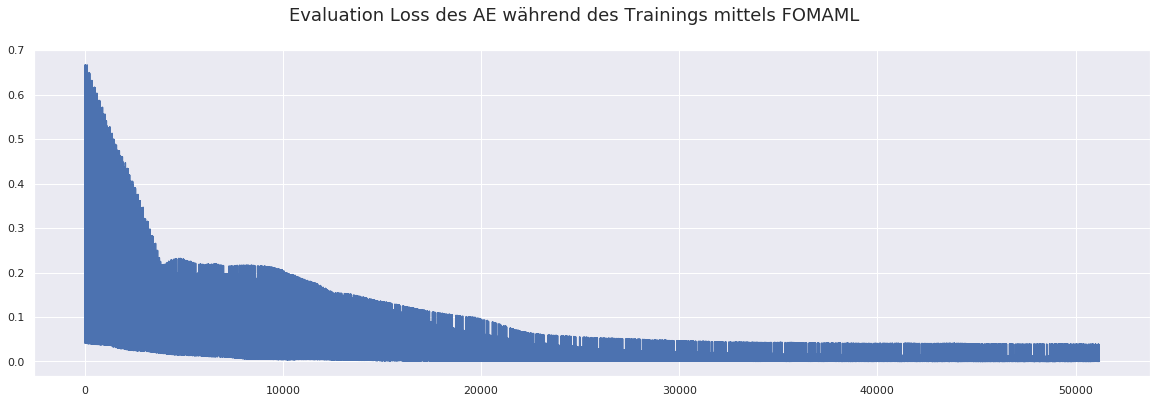

In [22]:
save = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.plot(eval_loss)
fig.suptitle('Evaluation Loss des AE während des Trainings mittels FOMAML', fontsize=18)

if save:
    fn = os.path.join(fig_path, 'eval_loss_after_meta_learning.pdf')
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)

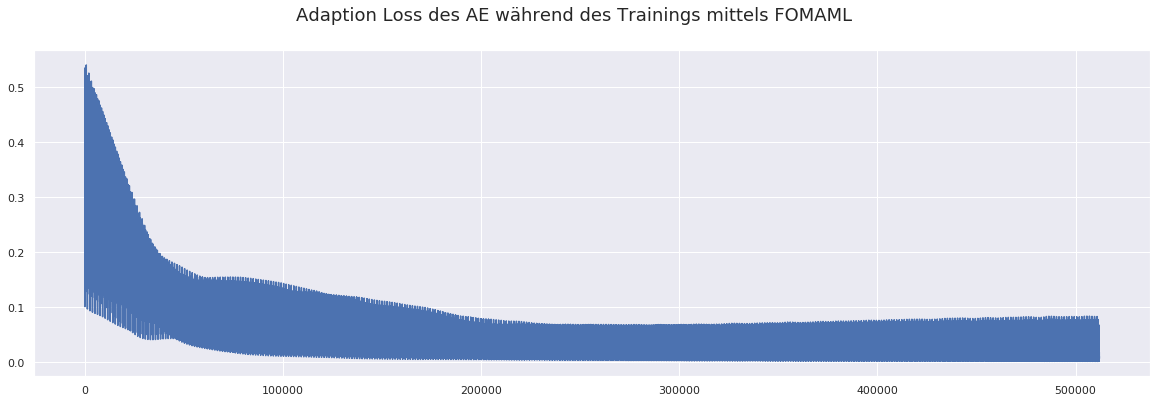

In [23]:
save = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 6)
ax.plot(adapt_loss)
fig.suptitle('Adaption Loss des AE während des Trainings mittels FOMAML', fontsize=18)

if save:
    fn = os.path.join(fig_path, 'adapt_loss_after_meta_learning.pdf')
    fig.savefig(fn, bbox_inches='tight', pad_inches=0)

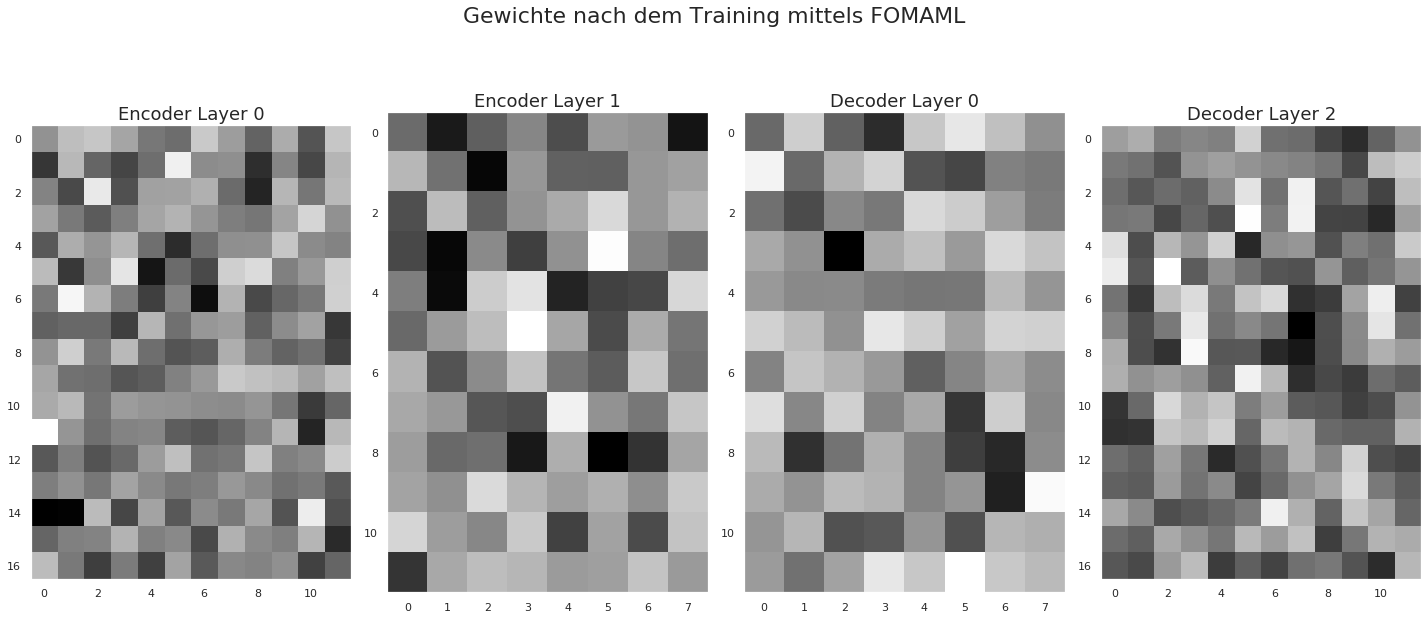

In [30]:
fig, ax = plt.subplots(ncols=4, nrows=1)
fig.set_size_inches(20, 10)

ax[0].imshow(meta_model.encoder[0].weight.detach().numpy().T, cmap="gray")
ax[0].grid(False)
ax[0].set_title('Encoder Layer 0', fontsize=18)

ax[1].imshow(meta_model.encoder[2].weight.detach().numpy().T, cmap="gray")
ax[1].grid(False)
ax[1].set_title('Encoder Layer 1', fontsize=18)

ax[2].imshow(meta_model.decoder[0].weight.detach().numpy(), cmap="gray")
ax[2].grid(False)
ax[2].set_title('Decoder Layer 0', fontsize=18)

ax[3].imshow(meta_model.decoder[2].weight.detach().numpy(), cmap="gray")
ax[3].grid(False)
ax[3].set_title('Decoder Layer 2', fontsize=18)
fig.suptitle('Gewichte nach dem Training mittels FOMAML', fontsize=22)
plt.tight_layout()

## Save Model

In [26]:
meta_model = learner.meta_model.module
type(meta_model)

models.SimpleAutoEncoder.SimpleAutoEncoder

In [29]:
model_fn = '{}_firstMetaModel.pt'.format(arrow.now().format('YYYYMMDD'))
print('Model Name: {}'.format(model_fn))
torch.save(meta_model.state_dict(), os.path.join(model_bib_path, model_fn))

Model Name: 20200319_firstMetaModel.pt


## Train LogReg for Threshold Learning
### Imports

In [36]:
from sklearn.linear_model import LogisticRegression
from utils.evalUtils import calc_cm_metrics

from models.SimpleAutoEncoder import SimpleAutoEncoder
torch.manual_seed(42)

### Prepare Data

In [37]:
data_fn = os.path.join(data_path, 'anomalous_data_y_2022_reduced.h5')
df_data_anormal = pd.read_hdf(data_fn, key='df')
print('Shape of simulation data: {}'.format(df_data_anormal.shape))

Shape of simulation data: (35040, 18)


In [38]:
s_labels = df_data_anormal['label']
df_data_anormal.drop('label', axis=1, inplace=True)

In [39]:
scaler_train = MinMaxScaler((-1,1))

In [40]:
scaler_train = scaler_train.fit(df_data_train)

In [41]:
scaled_anormal = scaler_train.transform(df_data_anormal.to_numpy())

In [42]:
# build tensor from numpy
anormal_torch_tensor = torch.from_numpy(scaled_anormal).type(torch.FloatTensor)

In [43]:
# build TensorDataset from Tensor
anormal_dataset = TensorDataset(anormal_torch_tensor, anormal_torch_tensor)

In [44]:
# build DataLoader from TensorDataset
anormal_dataloader = torch.utils.data.DataLoader(anormal_dataset,batch_size=128,shuffle=False, num_workers=0)

In [45]:
losses_X_test = []
for val in anormal_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_X_test.append(loss.item())
    
s_losses_X_test = pd.Series(losses_X_test)

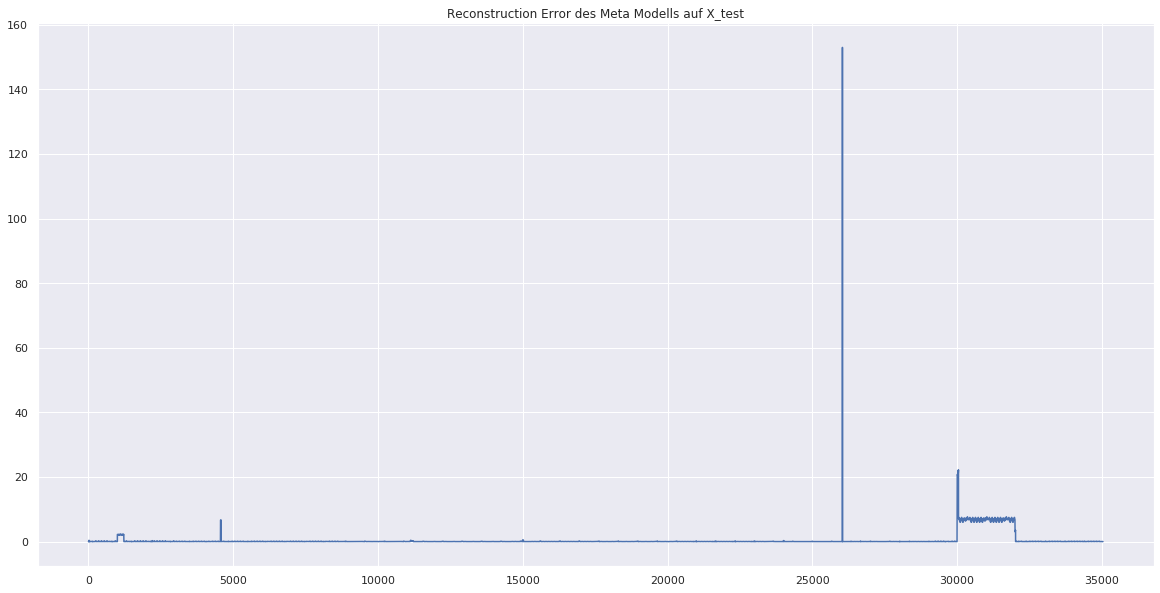

In [46]:
s_losses_X_test.plot(figsize=(20,10), title='Reconstruction Error des Meta Modells auf X_test')

In [47]:
X_x_test = s_losses_X_test.to_numpy()
X_x_test = X_x_test.reshape(-1, 1)
y_x_test = [1 if x > 0 else 0 for x in s_labels]

### Training

In [48]:
clf_meta = LogisticRegression(random_state=42, fit_intercept=True, solver='liblinear', class_weight={1:2.0})
clf_meta.fit(X_x_test, y_x_test)

LogisticRegression(C=1.0, class_weight={1: 2.0}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

### Save LogReg Model

In [50]:
import joblib

In [52]:
model_fn = '{}_LogReg_MetaModel.save'.format(arrow.now().format('YYYYMMDD'))
filename = os.path.join(model_bib_path, model_fn)
joblib.dump(clf_meta, filename)

['/home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/models/model_bib/20200319_LogReg_MetaModel.save']

### Evaluate trained LogReg

#### On X_test (with Anomalies)

In [54]:
predictions_X_test = []
for val in X_x_test:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_X_test.append(pred[0])

In [91]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from mlxtend.plotting import plot_confusion_matrix
import joblib

In [102]:
cm = confusion_matrix(y_x_test, predictions_X_test)
tn, fp, fn, tp  = confusion_matrix(y_x_test, predictions_X_test).ravel()

fn = np.int64(fn)

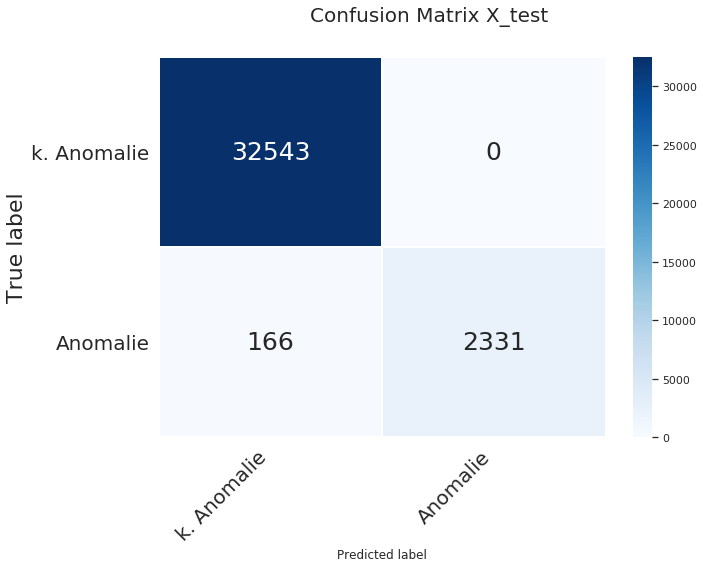

In [105]:
fig = print_confusion_matrix(cm, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_test', fontsize=20)
file_n = os.path.join(fig_path, 'cm_ano_x_test.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [107]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(int(tp), int(tn), int(fp), int(fn))
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 99.52625570773415
Precision: 99.999999999571
Specifity: 93.31593737452162
Sensitivity: 93.35202242653844
F1-Score: 96.56172328066164


#### On X_drifted (no Anomalies, but Concept Drift)

In [108]:
data_fn = os.path.join(data_path, 'drifted_data_y_2023_reduced_more_cos_phi.h5')
df_data_drifted = pd.read_hdf(data_fn, key='df')
print('Shape of X_drifted data: {}'.format(df_data_drifted.shape))

Shape of X_drifted data: (35040, 18)


In [109]:
s_drift_labels = df_data_drifted['drift_labels']
df_data_drifted.drop('drift_labels', axis=1, inplace=True)

In [110]:
scaled_drifted = scaler_train.transform(df_data_drifted.to_numpy())

In [111]:
# build tensor from numpy
drifted_torch_tensor = torch.from_numpy(scaled_drifted).type(torch.FloatTensor)

In [112]:
# build TensorDataset from Tensor
drifted_dataset = TensorDataset(drifted_torch_tensor, drifted_torch_tensor)

In [113]:
losses_X_drifted = []
for val in drifted_torch_tensor:
    loss = model.calc_reconstruction_error(val)
    losses_X_drifted.append(loss.item())
    
s_losses_drifted = pd.Series(losses_X_drifted)

In [114]:
X_drifted = s_losses_drifted.to_numpy()
X_drifted = X_drifted.reshape(-1, 1)
y_drifted = np.zeros(len(s_losses_drifted))

In [115]:
predictions_drifted = []
for val in X_drifted:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_drifted.append(pred[0])

In [138]:
cm = confusion_matrix(y_drifted, predictions_drifted)
tn, fp, fn, tp  = confusion_matrix(y_drifted, predictions_drifted).ravel()

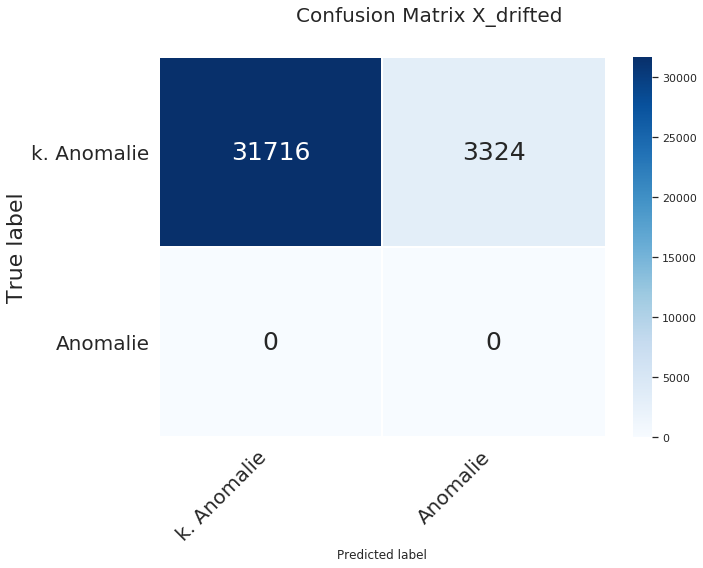

In [139]:
fig = print_confusion_matrix(cm, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted', fontsize=20)
fn = os.path.join(fig_path, 'cm_drifted.pdf')
fig.savefig(fn, bbox_inches = 'tight', pad_inches = 0 )

In [118]:
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))
print('TP: {}'.format(tp))
print('TN: {}'.format(tn))

FP: 3324
FN: /home/torge/dev/masterthesis_code/02_Experimente/MetaLearning/figs/cm_drifted.pdf
TP: 0
TN: 31716


In [85]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 90.51369863011116
Precision: 0.0
Specifity: 99.99999999996847
Sensitivity: 0.0
F1-Score: 0.0


#### On X_drifted,anormal

In [119]:
data_fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced_more_cos_phi.h5')
#data_fn = os.path.join(data_path, 'anomalous_drifted_data_y_2023_reduced.h5')

df_data_drifted_ano = pd.read_hdf(data_fn, key='df')
print('Shape of X_drift,ano data: {}'.format(df_data_drifted_ano.shape))

Shape of X_drift,ano data: (35040, 19)


In [120]:
s_drift_labels_drifted_ano = df_data_drifted_ano['drift_labels']
df_data_drifted_ano.drop('drift_labels', axis=1, inplace=True)

In [121]:
s_ano_labels_drifted_ano = df_data_drifted_ano['anomaly_labels']
df_data_drifted_ano.drop('anomaly_labels', axis=1, inplace=True)

In [122]:
scaled_drifted_ano = scaler_train.transform(df_data_drifted_ano.to_numpy())

In [123]:
# build tensor from numpy
drifted_ano_torch_tensor = torch.from_numpy(scaled_drifted_ano).type(torch.FloatTensor)

In [124]:
# build TensorDataset from Tensor
drifted_ano_dataset = TensorDataset(drifted_ano_torch_tensor, drifted_ano_torch_tensor)

In [125]:
losses_drifted_ano = []
for val in drifted_ano_dataset:
    loss = model.calc_reconstruction_error(val[0])
    losses_drifted_ano.append(loss.item())
    
s_losses_drifted_ano = pd.Series(losses_drifted_ano)

In [126]:
X_drifted_ano = s_losses_drifted_ano.to_numpy()
X_drifted_ano = X_drifted_ano.reshape(-1, 1)
y_drifted_ano = [1 if x > 0 else 0 for x in s_ano_labels_drifted_ano]

In [128]:
predictions_drifted_ano = []
for val in X_drifted_ano:
    val = val.reshape(1,-1)
    pred = clf_meta.predict(val)
    predictions_drifted_ano.append(pred[0])

In [132]:
cm = confusion_matrix(y_drifted_ano, predictions_drifted_ano)
tn, fp, fn, tp  = confusion_matrix(y_drifted_ano, predictions_drifted_ano).ravel()

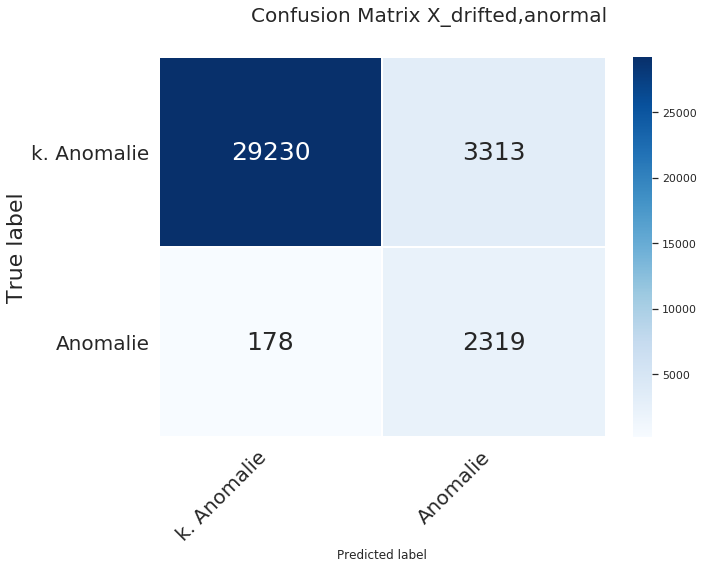

In [136]:
fig = print_confusion_matrix(cm, class_names=['k. Anomalie', 'Anomalie'])
fig.suptitle('Confusion Matrix X_drifted,anormal', fontsize=20)
file_n = os.path.join(fig_path, 'cm_drifted_ano.pdf')
fig.savefig(file_n, bbox_inches = 'tight', pad_inches = 0 )

In [134]:
print('FP: {}'.format(fp))
print('FN: {}'.format(fn))
print('TP: {}'.format(tp))
print('TN: {}'.format(tn))

FP: 3313
FN: 178
TP: 2319
TN: 29230


In [135]:
accuracy, precision, specifity, sensitivity, f1_score = calc_cm_metrics(tp, tn, fp, fn)
print('Accuracy: {}'.format(accuracy))
print('Precision: {}'.format(precision))
print('Specifity: {}'.format(specifity))
print('Sensitivity: {}'.format(sensitivity))
print('F1-Score: {}'.format(f1_score))

Accuracy: 90.03710045659533
Precision: 41.175426136290525
Specifity: 92.64952930359357
Sensitivity: 92.87144573450993
F1-Score: 57.054988313375496
